In [12]:
import json
import pylab as pl
import datetime as dt
import time 
from twython import Twython
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial

    try:
         window_size = np.abs(np.int(window_size))
         order = np.abs(np.int(order))
    except ValueError, msg:
         raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')



In [6]:
consumer_key = 'SwGQwAwsOV5ESsyyWhg7yaNw1'
consumer_secret = 'lkV7ZoiRrDEnaPVBmJD7adZv4ov5bY6X7v7ijbMuoZ0GFEbS2d'
access_token = '22366359-ggdgYSdEXxpm19CgFVHd111FWITTDNEYehMFySAxg'
access_secret = 'ylmtUI9ni0Mb8DhoGKZIKPeY8kOgqFIYijmLab09PlTFk'
twitter = Twython(consumer_key, consumer_secret,
                  access_token, access_secret)


user = "realDonaldTrump"
user_timeline = twitter.get_user_timeline(screen_name=user,count=1)


In [3]:
lis = [user_timeline[0]['id']] ## this is the latest starting tweet id
#lis = [791738173462310912]
rdttweets = []

for i in [0]:
    user_timeline = twitter.get_user_timeline(screen_name=user,
    count=200, include_retweets=False, max_id=lis[-1])
    for tweet in user_timeline:
        rdttweets.append(tweet) ## append the tweet
        lis.append(tweet['id']) ## append tweet id's
with open('rdttweets2.json', 'w') as fp:
    json.dump(rdttweets, fp)


In [5]:
MULTI = True
if MULTI:
    for i in range(1, 16): ## iterate through all tweets
## tweet extract method with the last list item as the max_id
        user_timeline = twitter.get_user_timeline(screen_name=user,
        count=200, include_retweets=False, max_id=lis[-1])
        
        for tweet in user_timeline:
            rdttweets.append(tweet) ## append the tweet
            lis.append(tweet['id']) ## append tweet id's
        time.sleep(300) ## 5 minute rest between api calls
    with open('rdttweets2.json', 'w') as fp:
        json.dump(rdttweets, fp)


In [9]:
json_data=open("rdttweets2.json").read()

rdttweets = json.loads(json_data)

print(len(rdttweets))


3199


In [10]:
rdttweets[0].keys()

[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'source',
 u'retweeted',
 u'coordinates',
 u'entities',
 u'in_reply_to_screen_name',
 u'id_str',
 u'retweet_count',
 u'in_reply_to_user_id',
 u'favorited',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'possibly_sensitive',
 u'lang',
 u'created_at',
 u'in_reply_to_status_id_str',
 u'place']

In [13]:
texttweets = np.array([tt['text'] for tt in rdttweets])
retweets = np.array([tt['retweet_count'] for tt in rdttweets])
liketweets = np.array([tt['favorite_count'] for tt in rdttweets])

tweetstime = np.array([tt['created_at'] for tt in rdttweets])
ttimes = [dt.datetime.strptime(tts.replace('+','00'), '%a %b %d %H:%M:%S %f %Y') for tts in tweetstime]
ttimes = np.array(ttimes)

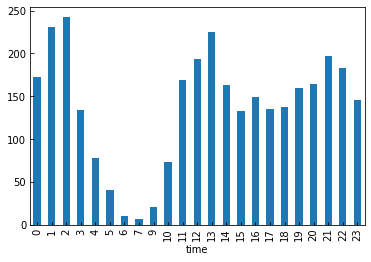

In [14]:
delta = datetime.timedelta(hours=72)
df = pd.DataFrame({'time':ttimes, 'likes':liketweets, 'rts':retweets})
df['UnixStamp'] = df['time'].apply(lambda d: time.mktime(d.timetuple()))
pl.figure()
df['likes'].groupby([df['time'].apply(lambda x:x.hour)]).agg(pd.Series.nunique).plot(kind='bar')
pl.title("likes")
pl.figure()
df['rts'].groupby([df['time'].apply(lambda x:x.hour)]).agg(pd.Series.nunique).plot(kind='bar')
pl.title("retweets")




In [ ]:
df = df.groupby([df['time'].dt.to_period('D'), 'likes']).count().unstack()
# Droping unnecessary column level
df.columns = df.columns.droplevel()
df.plot(kind='bar')


TypeError: expected sequence object with len >= 0 or a single integer

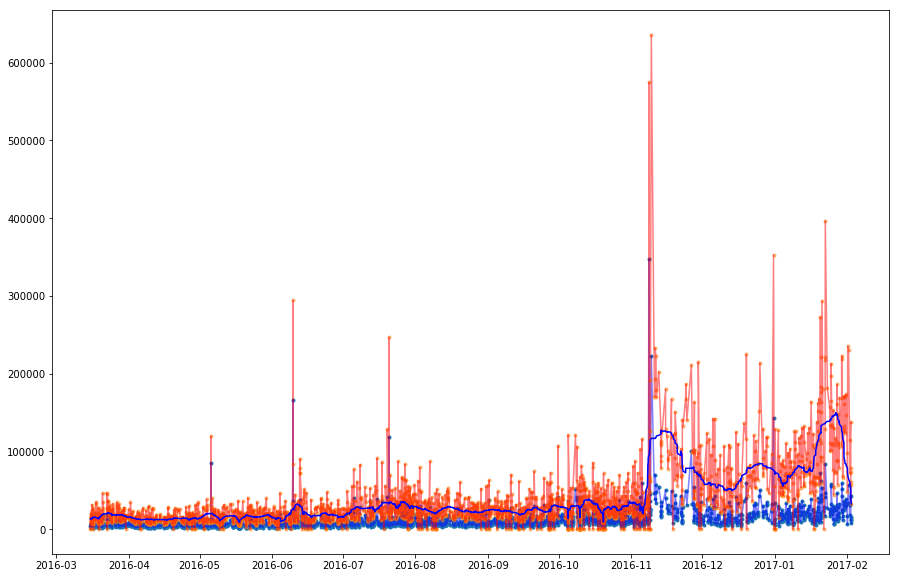

In [73]:
pl.figure(figsize=(15,10))
pl.plot(ttimes, retweets, '.')
pl.plot(ttimes, retweets, 'b-', alpha=0.5)
pl.plot(ttimes, liketweets, '.', alpha=0.5)
pl.plot(ttimes, liketweets, 'r-', alpha=0.5)
len(ttimes)
pl.plot(ttimes, savitzky_golay(liketweets, 99, 2), 'b-') # window size 51, polynomial order 3
np.histogram(liketweets[ttimes<dt.datetime(2016, 11, 8)], bins=dt.timedelta(days=3))

In [14]:
texttweets[np.where(liketweets==liketweets.max())[0]]

array([ u'Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before'], 
      dtype='<U152')

In [32]:
ttimes[liketweets == max(liketweets)],  max(liketweets)

(array([datetime.datetime(2016, 11, 9, 11, 36, 58)], dtype=object), 635854)

In [23]:
texttweets[np.where(retweets==retweets.max())[0]]

array([u'TODAY WE MAKE AMERICA GREAT AGAIN!'], 
      dtype='<U152')

In [24]:
ttimes[retweets == max(retweets)]

array([datetime.datetime(2016, 11, 8, 11, 43, 14)], dtype=object)

In [26]:
import scipy as sp
sp.stats.pearsonr(retweets, liketweets)

(0.87407239362679456, 0.0)

In [45]:
texttweets[liketweets.argsort()][-10:]

array([ u'Just had a very open and successful presidential election. Now professional protesters, incited by the media, are protesting. Very unfair!',
       u'Hope you like my nomination of Judge Neil Gorsuch for the United States Supreme Court. He is a good and brilliant man, respected by all.',
       u"The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emails.",
       u'It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!',
       u'THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN\U0001f1fa\U0001f1f8 https://t.co/V3aoj9RUh4',
       u'How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/gECLNtQizQ',
       u"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do.

In [47]:
texttweets[retweets.argsort()][-10:]

array([ u'It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!',
       u'Nobody should be allowed to burn the American flag - if they do, there must be consequences - perhaps loss of citizenship or year in jail!',
       u"Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views.",
       u'Happy #CincoDeMayo! The best taco bowls are made in Trump Tower Grill. I love Hispanics! https://t.co/ufoTeQd8yA https://t.co/k01Mc6CuDI',
       u'Fidel Castro is dead!',
       u"The media is spending more time doing a forensic analysis of Melania's speech than the FBI spent on Hillary's emails.",
       u"Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!",
       u'How long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you de

In [48]:
liketweets[liketweets.argsort()][-10:]


array([232680, 235011, 246669, 272789, 293556, 294142, 352747, 396616,
       575212, 635854])

In [49]:
retweets[retweets.argsort()][-10:]


array([ 72597,  73325,  83541,  85247, 100432, 118965, 143156, 166287,
       222582, 347302])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(array([  46.,  313.,  639.,  920.,  642.,  237.,  117.,   83.,   27.,    7.]),
 array([ 0.12117605,  0.18032091,  0.23946576,  0.29861061,  0.35775546,
         0.41690031,  0.47604516,  0.53519001,  0.59433486,  0.65347971,
         0.71262456]),
 <a list of 10 Patch objects>)

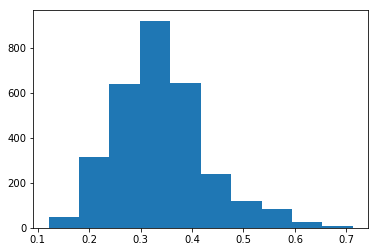

In [56]:
pl.hist((retweets.astype(float)/liketweets.astype(float))[np.isfinite(retweets.astype(float)/liketweets.astype(float))])